# STANDALONE STUDY
## **STEWART GOUGH PLATFORM**
-----------------------------

### **IMPORTANT NOTES**
#### **COLAB Machine Setup**
If starting a new Colab session, Please open the [colab_setup.ipynb](https://colab.research.google.com/github/khaledghobashy/smbd/blob/master/examples/notebooks/colab_setup.ipynb) and follow the instructions there.
A new Colab session does not mean a new notebook session, you can have various notebook sessions on the same Colab session. The Colab session linked to your Google account expires in 12 hours, and so any data saved on that remote machine will be lost.</br>
When you run the first cell, Colab will prompt a warning that *"This notebook was not authored by Google."* and that it is loaded from GitHub. Un-check the **Reset all runtimes before running** then press **RUN ANYWAY**.

#### **Package Path.**
*This step is temporary unitll the package can be installed via conda and/or pip*
- **Colab**. </br>
For a Cloab session, the ```pkg_path``` variable is the one relevant to the repository path on the Colab remote machine. This should be used if you are running the notebook on Colab.
- **Local Machine**. </br>
The ```pkg_path``` variable is where I have the repository on my machine. You should change it to where you cloned the repository on your machine.

#### **Projects Directory**
- **Colab**.</br>
The ```projects_dir``` variable should not be changed.
- **Local Machine**. </br>
The ```projects_dir``` should be changed to match your desired directory where you store your projects.

--------------------------------------------------------------

In [1]:
import sys

In [2]:
project_name = 'stewart_gough'

### Colab Session
*Run if in a Colab Session Only!*

In [2]:
project_dir = '/content/projects/%s'%project_name
pkg_path = '/content/smbd'
sys.path.append(pkg_path)

### Local Session
*Run if on your Local Machine!*</br>
*Do not forget to change the variables below as illustrated in the notes!*

In [3]:
project_dir = ''
pkg_path = '/home/khaledghobashy/Documents/smbd'
sys.path.append(pkg_path)

---------------------------------------------------------------
---------------------------------------------------------------

In [4]:
from smbd.systems import standalone_project, standalone_topology, configuration

In [5]:
project = standalone_project(project_dir)
project.create()

---------------------------------------------------------------
---------------------------------------------------------------

## **SYSTEM DESCRIPTION**
-------------------------

### **Important Note**
The tool uses [euler-parameters](https://en.wikibooks.org/wiki/Multibody_Mechanics/Euler_Parameters) -which is a 4D unit quaternion- to represents bodies orientation in space. This makes the generalized coordinates used to fully define a body in space to be **7,** instead of **6**, it also adds an algebraic equation to the constraints that ensures the unity/normalization of the body quaternion. This is an important remark as the calculations of the degrees-of-freedom depends on it.

### **Summary**
A Stewart–Gough platform is a type of parallel manipulators. It consists mainly of a moving table that is supported to the ground through a set of prismatic actuators that can be actuatead directly, or a set of rigid links, where each link is connected to a rocker that can be actuated by a servo motor.</br>
The platform exists in various topologies depending on the desired degrees-of-freedom (DOF) and the actuation method used. More information about the mechanism can be found on [wikipedia](https://en.wikipedia.org/wiki/Stewart_platform).</br>

The modeled system is a **3-DOF** mechanism that allows the table to move freely in the Z-axis $z$ as well as to rotate freely about the X-axis and the Y-axis, pitch $\phi$ and roll $\theta$ respectively. These movements can be controlled through the angles of the servo motors used down at the rockers to give the desired motion path of the table.


### **Topology Layout**
The mechanism consists of 7 Bodies + 1 Ground. Therefore, total system coordinates -including the ground- is $$n=n_b\times7 = 8\times7 = 56$$ 
where $n_b$ is the total number of bodies. The list of bodies is given below:
    - 1 Table.
    - 3 Rockers.
    - 3 Connecting-Rods.

The system connectivity is as follows:
- Each rocker is connected to the ground by a revolute joint. 
    - Total $3$ joints resulting in constraint equations $n_{c,rev} = 15$
- Each connecting-rod is connected to the corresponding rocker by a spherical joint.
    - Total $3$ joints resulting in constraint equations $n_{c,sph} = 9$
- The table is connected to each connecting-rod by a universal joint.
    - Total $3$ joints resulting in constraint equations $n_{c,uni} = 12$
- The table is connected directly to the ground by a tripod joint.
    - Total $1$ joints resulting in constraint equations $n_{c,tri} = 3$
- Total free DOF is $$n-( n_{c,rev}+n_{c,sph}+n_{c,uni}+n_{c,tri}+n_{c,P}+n_{c,g}) = 56-(15+9+12+3+(7\times1)+7) = 56-53 = 3$$, where the $n_{c,P}$ and $n_{c,g}$ represents the constraints due to euler-parameters normalization equations and the ground-constraints respectively.
- The bottom revolute joints are actuated by a rotational actuators. 
    - Total $3$ actuators resulting in constraint equations $n_{c,act} = 3$

---------------------------------------------------------------
---------------------------------------------------------------

## **SYMBOLIC TOPOLOGY**
------------------------

In this section, we create the symbolic topology that captures the topological layout that we just discussed.</br>
Defining the topology is very simple. We start by importing the ```standalone_topology``` class and create a new instance that represents our symbolic model. Then we start adding the components we discussed earlier, starting by the bodies, then the joints, actuators and forces, and thats it.</br>
These components will be represented symbolically, and therefore there is no need for any numerical inputs at this step.

The system is stored in a form of a network graph that stores all the data needed for the assemblage of the system equations later. But even before the assemblage process, we can gain helpful insights about our system as well be shown.


In [6]:
sym_model = standalone_topology(project_name)

### Adding Bodies

In [7]:
sym_model.add_body('table')

sym_model.add_body('link_1')
sym_model.add_body('link_2')
sym_model.add_body('link_3')

sym_model.add_body('rocker_1')
sym_model.add_body('rocker_2')
sym_model.add_body('rocker_3')


### Adding Joints

In [8]:
# Revolute joints connecting the rockers to the ground.
sym_model.add_joint.revolute('rev_1', 'ground', 'rbs_rocker_1')
sym_model.add_joint.revolute('rev_2', 'ground', 'rbs_rocker_2')
sym_model.add_joint.revolute('rev_3', 'ground', 'rbs_rocker_3')

# Sperical joints connecting the connecting-rods to the rockers.
sym_model.add_joint.spherical('bottom_sph_1', 'rbs_rocker_1', 'rbs_link_1')
sym_model.add_joint.spherical('bottom_sph_2', 'rbs_rocker_2', 'rbs_link_2')
sym_model.add_joint.spherical('bottom_sph_3', 'rbs_rocker_3', 'rbs_link_3')

# Universal joints connecting the moving-table to the connecting-rods.
sym_model.add_joint.universal('upper_uni_1', 'rbs_link_1', 'rbs_table')
sym_model.add_joint.universal('upper_uni_2', 'rbs_link_2', 'rbs_table')
sym_model.add_joint.universal('upper_uni_3', 'rbs_link_3', 'rbs_table')

# Tripod joint connecting the moving-table to the ground.
sym_model.add_joint.tripod('tripod', 'rbs_table', 'ground')

#### **Checking the system status so far.**

In [10]:
sym_model.topology.n, sym_model.topology.nc

(56, 53)

### Adding Actuators

Here we add the desired actuators to drive the system, which will make the system fully defined kinematically.

In [11]:
sym_model.add_actuator.rotational_actuator('act_1', 'jcs_rev_1')
sym_model.add_actuator.rotational_actuator('act_2', 'jcs_rev_2')
sym_model.add_actuator.rotational_actuator('act_3', 'jcs_rev_3')


In [12]:
sym_model.topology.n, sym_model.topology.nc

(56, 56)

### Adding Forces

In [10]:
#model.add_force.internal_force('force_name', 'body_1', 'body_2', mirror=False)

### **SYMBOLIC CHARACTERISTICS**

#### Topology Graph
Visualizing the connectivity of the system as a network graph, where the nodes represent the bodies, and the edges represent the joints, forces and/or actuators between the bodies.

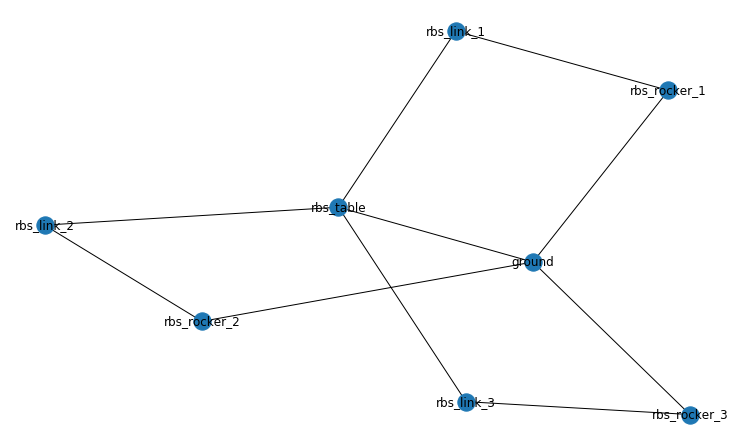

In [13]:
sym_model.topology.draw_constraints_topology()

### **ASSEMBLING**

This is the last step of the symbolic building process, where we make the system starts the assemblage process of the governing equations, which will be used then in the code generation for the numerical simulation, and also can be used for further symbolic manipulations.</br>

*Note: The equations' notations will be discussed in the tool documentation files.*

In [14]:
sym_model.assemble()

#### Checking the System Equations.

In [15]:
sym_model.topology.pos_equations

Matrix([
[                                                                                                                               A({P_{ground}})*{\bar{u}^{ground}_{jcs_rev_1}} - A({P_{rbs_rocker_1}})*{\bar{u}^{rbs_rocker_1}_{jcs_rev_1}} + {R_{ground}} - {R_{rbs_rocker_1}}],
[                                                                                                                                                               Mbar_ground_jcs_rev_1[:,(0, 1)].T*A({P_{ground}}).T*A({P_{rbs_rocker_1}})*Mbar_rbs_rocker_1_jcs_rev_1[:,(2, 3)]],
[                                                                                                                                                               Mbar_ground_jcs_rev_1[:,(1, 2)].T*A({P_{ground}}).T*A({P_{rbs_rocker_1}})*Mbar_rbs_rocker_1_jcs_rev_1[:,(2, 3)]],
[(-sin(UF_mcs_act_1(t)))*Mbar_ground_jcs_rev_1[:,(0, 1)].T*A({P_{ground}}).T*A({P_{rbs_rocker_1}})*Mbar_rbs_rocker_1_jcs_rev_1[:,(0, 1)] + cos(UF_mcs_act_1(t))*Mbar_grou

---------------------------------------------------------------
---------------------------------------------------------------

## **SYSTEM CONFIGURATION**
---------------------------

In this step we define a symbolic configuration of our symbolic topology. As you may have noticed in the symbolic topology building step, we only cared about the *'topology'*, thats is the system bodies and their connectivity, and we did not care explicitly with how these components are configured in space.</br>
In order to create a valid numerical simulation session, we have to provide the system with its numerical configuration needed, for example, the joints' locations and orientations. The symbolic topology in its raw form will require you to manually enter all these numerical arguments, which can be cumbersome even for smaller systems. This can be checked by checking the configuration inputs of the symbolic configuration as ```config._config.input_nodes```

Here we start by stating the symbolic inputs we wish to use instead of the default inputs set, and then we define the relation between these newly defined arguments and the original ones. The details of this process will be provided in the documentation.

In [16]:
config_name = '%s_cfg'%project_name
config = configuration(config_name, sym_model)

In [17]:
config.config.input_nodes

['ax1_jcs_rev_1',
 'pt1_jcs_rev_1',
 'UF_mcs_act_1',
 'ax1_jcs_rev_2',
 'pt1_jcs_rev_2',
 'UF_mcs_act_2',
 'ax1_jcs_rev_3',
 'pt1_jcs_rev_3',
 'UF_mcs_act_3',
 'ax1_jcs_tripod',
 'pt1_jcs_tripod',
 'ax1_jcs_upper_uni_1',
 'ax2_jcs_upper_uni_1',
 'pt1_jcs_upper_uni_1',
 'ax1_jcs_upper_uni_2',
 'ax2_jcs_upper_uni_2',
 'pt1_jcs_upper_uni_2',
 'ax1_jcs_upper_uni_3',
 'ax2_jcs_upper_uni_3',
 'pt1_jcs_upper_uni_3',
 'ax1_jcs_bottom_sph_1',
 'pt1_jcs_bottom_sph_1',
 'ax1_jcs_bottom_sph_2',
 'pt1_jcs_bottom_sph_2',
 'ax1_jcs_bottom_sph_3',
 'pt1_jcs_bottom_sph_3',
 'R_ground',
 'P_ground',
 'Rd_ground',
 'Pd_ground',
 'Rdd_ground',
 'Pdd_ground',
 'R_rbs_table',
 'P_rbs_table',
 'Rd_rbs_table',
 'Pd_rbs_table',
 'Rdd_rbs_table',
 'Pdd_rbs_table',
 'm_rbs_table',
 'Jbar_rbs_table',
 'R_rbs_link_1',
 'P_rbs_link_1',
 'Rd_rbs_link_1',
 'Pd_rbs_link_1',
 'Rdd_rbs_link_1',
 'Pdd_rbs_link_1',
 'm_rbs_link_1',
 'Jbar_rbs_link_1',
 'R_rbs_link_2',
 'P_rbs_link_2',
 'Rd_rbs_link_2',
 'Pd_rbs_link_2',
 

### CONFIGURATION INPUTS

In [18]:
config.add_point.UserInput('bottom_1')
config.add_point.UserInput('bottom_2')
config.add_point.UserInput('bottom_3')
config.add_point.UserInput('middle_1')
config.add_point.UserInput('middle_2')
config.add_point.UserInput('middle_3')
config.add_point.UserInput('upper_1')
config.add_point.UserInput('upper_2')
config.add_point.UserInput('upper_3')
config.add_point.UserInput('tripod')

config.add_vector.UserInput('y')
config.add_vector.UserInput('z')

### CONFIGURATION RELATIONS

In [19]:
# Bottom Revolute Joints:
config.add_relation.Equal_to('pt1_jcs_rev_1', ('hps_bottom_1',))
config.add_relation.Equal_to('ax1_jcs_rev_1', ('vcs_y',))

config.add_relation.Equal_to('pt1_jcs_rev_2', ('hps_bottom_2',))
config.add_relation.Equal_to('ax1_jcs_rev_2', ('vcs_y',))

config.add_relation.Equal_to('pt1_jcs_rev_3', ('hps_bottom_3',))
config.add_relation.Equal_to('ax1_jcs_rev_3', ('vcs_y',))

# Bottom Spherical Joints:
config.add_relation.Equal_to('pt1_jcs_bottom_sph_1', ('hps_middle_1',))
config.add_relation.Equal_to('ax1_jcs_bottom_sph_1', ('vcs_z',))

config.add_relation.Equal_to('pt1_jcs_bottom_sph_2', ('hps_middle_2',))
config.add_relation.Equal_to('ax1_jcs_bottom_sph_2', ('vcs_z',))

config.add_relation.Equal_to('pt1_jcs_bottom_sph_3', ('hps_middle_3',))
config.add_relation.Equal_to('ax1_jcs_bottom_sph_3', ('vcs_z',))

# Upper Universal Joints:
config.add_relation.Equal_to('pt1_jcs_upper_uni_1', ('hps_upper_1',))
config.add_relation.Oriented('ax1_jcs_upper_uni_1', ('hps_middle_1', 'hps_upper_1'))
config.add_relation.Equal_to('ax2_jcs_upper_uni_1', ('vcs_z',))

config.add_relation.Equal_to('pt1_jcs_upper_uni_2', ('hps_upper_2',))
config.add_relation.Oriented('ax1_jcs_upper_uni_2', ('hps_middle_2', 'hps_upper_2'))
config.add_relation.Equal_to('ax2_jcs_upper_uni_2', ('vcs_z',))

config.add_relation.Equal_to('pt1_jcs_upper_uni_3', ('hps_upper_3',))
config.add_relation.Oriented('ax1_jcs_upper_uni_3', ('hps_middle_3', 'hps_upper_3'))
config.add_relation.Equal_to('ax2_jcs_upper_uni_3', ('vcs_z',))

# Upper Tripod Joint:
config.add_relation.Equal_to('pt1_jcs_tripod', ('hps_tripod',))
config.add_relation.Equal_to('ax1_jcs_tripod', ('vcs_z',))


### GEOMETRIES

Here we start defining basic geometric shapes that can represents the shapes of the bodies in our system. This serves two points:
- Visualization and Animation in blender.
- Evaluating the bodies inertia properties from these basic geometries instead of explicit definition.

In [20]:
config.add_scalar.UserInput('links_ro')
config.add_scalar.UserInput('rockers_ro')

config.add_geometry.Triangular_Prism('table', ('hps_upper_1','hps_upper_2','hps_upper_3','s_rockers_ro'))
config.assign_geometry_to_body('rbs_table', 'gms_table')

config.add_geometry.Cylinder_Geometry('rocker_1', ('hps_bottom_1','hps_middle_1','s_rockers_ro'))
config.assign_geometry_to_body('rbs_rocker_1', 'gms_rocker_1')

config.add_geometry.Cylinder_Geometry('rocker_2', ('hps_bottom_2','hps_middle_2','s_rockers_ro'))
config.assign_geometry_to_body('rbs_rocker_2', 'gms_rocker_2')

config.add_geometry.Cylinder_Geometry('rocker_3', ('hps_bottom_3','hps_middle_3','s_rockers_ro'))
config.assign_geometry_to_body('rbs_rocker_3', 'gms_rocker_3')

config.add_geometry.Cylinder_Geometry('link_1', ('hps_upper_1','hps_middle_1','s_links_ro'))
config.assign_geometry_to_body('rbs_link_1', 'gms_link_1')

config.add_geometry.Cylinder_Geometry('link_2', ('hps_upper_2','hps_middle_2','s_links_ro'))
config.assign_geometry_to_body('rbs_link_2', 'gms_link_2')

config.add_geometry.Cylinder_Geometry('link_3', ('hps_upper_3','hps_middle_3','s_links_ro'))
config.assign_geometry_to_body('rbs_link_3', 'gms_link_3')


Now lets check the current ```input_nodes```.

In [21]:
config.config.input_nodes

['UF_mcs_act_1',
 'UF_mcs_act_2',
 'UF_mcs_act_3',
 'R_ground',
 'P_ground',
 'Rd_ground',
 'Pd_ground',
 'Rdd_ground',
 'Pdd_ground',
 'Rd_rbs_table',
 'Pd_rbs_table',
 'Rdd_rbs_table',
 'Pdd_rbs_table',
 'Rd_rbs_link_1',
 'Pd_rbs_link_1',
 'Rdd_rbs_link_1',
 'Pdd_rbs_link_1',
 'Rd_rbs_link_2',
 'Pd_rbs_link_2',
 'Rdd_rbs_link_2',
 'Pdd_rbs_link_2',
 'Rd_rbs_link_3',
 'Pd_rbs_link_3',
 'Rdd_rbs_link_3',
 'Pdd_rbs_link_3',
 'Rd_rbs_rocker_1',
 'Pd_rbs_rocker_1',
 'Rdd_rbs_rocker_1',
 'Pdd_rbs_rocker_1',
 'Rd_rbs_rocker_2',
 'Pd_rbs_rocker_2',
 'Rdd_rbs_rocker_2',
 'Pdd_rbs_rocker_2',
 'Rd_rbs_rocker_3',
 'Pd_rbs_rocker_3',
 'Rdd_rbs_rocker_3',
 'Pdd_rbs_rocker_3',
 'hps_bottom_1',
 'hps_bottom_2',
 'hps_bottom_3',
 'hps_middle_1',
 'hps_middle_2',
 'hps_middle_3',
 'hps_upper_1',
 'hps_upper_2',
 'hps_upper_3',
 'hps_tripod',
 'vcs_y',
 'vcs_z',
 's_links_ro',
 's_rockers_ro']

### ASSEMBLING

Finally we assemble the system and extract the inputs' nodes to a .csv file that can be used to fill in the numerical values for a numerical simulation.

In [22]:
config.assemble()
config.extract_inputs_to_csv('config_inputs/')

---------------------------------------------------------------
---------------------------------------------------------------

## **CODE GENERATION**
----------------------

This step aims to create a valid code that can be used for numerical simulation. We will use the ***python code generators*** to create a valid numerical simulation environment in python.</br>
Theoretically, the symbolic environment is uncoupled from the simulation environment, which opens the door to create various simulation environments that can be in any language.

### Generating Python Numerical Environment

In [23]:
from smbd.numenv.python.codegen import projects as py_numenv

In [24]:
py_project = py_numenv.standalone_project(parent_dir='')
py_project.create_dirs()
py_project.write_topology_code(sym_model.topology)
py_project.write_configuration_code(config.config)
py_project.write_mainfile()

File full path : numenv/python/src/stewart_gough.py
File full path : numenv/python/src/stewart_gough_cfg.py
File full path : numenv/python/main.py


### Generating C++ Numerical Environment

In [25]:
from smbd.numenv.cpp_eigen.codegen import projects as cpp_numenv

In [26]:
cpp_project = cpp_numenv.standalone_project(parent_dir='')
cpp_project.create_dirs()
cpp_project.write_topology_code(sym_model.topology)
cpp_project.write_configuration_code(config.config)
cpp_project.write_mainfile()
cpp_project.write_makefile()

File full path : numenv/cpp_eigen/src/stewart_gough.hpp
File full path : numenv/cpp_eigen/src/stewart_gough.cpp
File full path : numenv/cpp_eigen/src/stewart_gough_cfg.hpp
File full path : numenv/cpp_eigen/main.cpp
File full path : numenv/cpp_eigen/Makefile


### Generating Blender Script

In [27]:
from smbd.utilities.blender import codegen

In [29]:
blender_code = codegen.script_generator(config.config)
blender_code.write_code_file('numenv/')

---------------------------------------------------------------
---------------------------------------------------------------

## **PYTHON NUMERICAL SIMULATION**
---------------------------

The **numerical simulation** step is also a straight forward one. We start by importing helper libraries like **numpy** and **pandas**, then we import the ```multibody_system``` class and ```simulation``` class that will be used to create a numerical system and a simulation instance respectively. And finally we import the generated code files from the previous step.

The steps then can be summarized as follows:
1. Create a numerical model instance by passing the generated topology code to the ```multibody_system``` class.
2. Make the configuration of that instance refers to the generated configuration code.
3. Setting the numerical data of the configuration, either directly here or via filling in the generated csv file.
4. Setting the **user-defined functions** that will be used for the actuators.
5. Creating a **simulation instance**, set the desired time-sampling and run the simulation.
6. Plotting the results.

###  Imports

In [30]:
import numpy as np
import pandas as pd

In [31]:
from smbd.numenv.python.numerics.systems import multibody_system, simulation

In [32]:
from numenv.python.src import stewart_gough, stewart_gough_cfg

### Creating Numerical Model

In [33]:
num_model = multibody_system(stewart_gough)
num_model.topology.config = stewart_gough_cfg.configuration()

### Setting Configuration Numerical Data

In [34]:
inputs_df = pd.read_csv('config_inputs/stewart_gough_cfg.csv', index_col=0)

In [35]:
inputs_df.loc['P_ground'] = [1, 0, 0, 0]

inputs_df.loc['hps_tripod'] = [0, 0, 390, 0]

inputs_df.loc['hps_bottom_1'] = [0, -430, 0, 0]
inputs_df.loc['hps_bottom_2'] = [139,  215, 0, 0]
inputs_df.loc['hps_bottom_3'] = [-139, 215, 0, 0]

inputs_df.loc['hps_middle_1'] = [-100, -430, 0, 0]
inputs_df.loc['hps_middle_2'] = [39, 215, 0, 0]
inputs_df.loc['hps_middle_3'] = [-39, 215, 0, 0]

inputs_df.loc['hps_upper_1'] = [0,  -430, 430, 0]
inputs_df.loc['hps_upper_2'] = [139, 215, 430, 0]
inputs_df.loc['hps_upper_3'] = [-139, 215, 430, 0]

inputs_df.loc['vcs_y'] = [0,1,0,0]
inputs_df.loc['vcs_z'] = [0,0,1,0]

inputs_df.loc['s_links_ro'] = [20,0,0,0]
inputs_df.loc['s_rockers_ro'] = [20,0,0,0]


In [36]:
# Saving the numerical data to a new csv file
inputs_df.to_csv('config_inputs/stewart_gough_v1.csv')

In [37]:
num_model.topology.config.load_from_dataframe(inputs_df)

### Setting User Functions.

#### Actuators

Here we set the actuation functions of the system actuators.

In [53]:
num_model.topology.config.UF_mcs_act_1 = lambda t :  np.deg2rad(360)*t
num_model.topology.config.UF_mcs_act_2 = lambda t :  np.deg2rad(360)*t
num_model.topology.config.UF_mcs_act_3 = lambda t :  np.deg2rad(360)*t

### Creating Simulation Instance

A simulation instance takes in three arguments, the simulation ```name```, the numerical ```model``` and the simulation ```typ```. The simulation ```typ``` argument should be either *kds* for kinematically driven systems or *dds* for dynamically driven systems. For our case, the system is fully defined kinematically, and therefore we will set the ```typ``` as *kds*.

In [54]:
sim1 = simulation('sim1', num_model, 'kds')
sim1.set_time_array(3, 300)
sim1.solve()


Running System Kinematic Analysis:
[=========================] 100%, (299/299) steps.



### Plotting Results

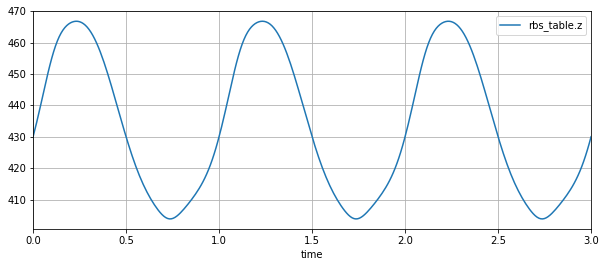

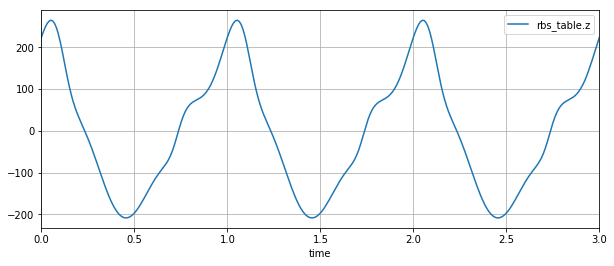

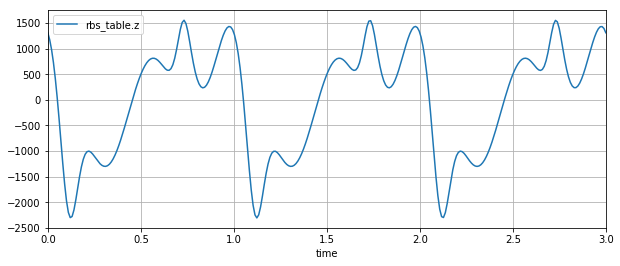

In [55]:
sim1.soln.pos_dataframe.plot(x='time', y='rbs_table.z', grid=True, figsize=(10,4))
sim1.soln.vel_dataframe.plot(x='time', y='rbs_table.z', grid=True, figsize=(10,4))
sim1.soln.acc_dataframe.plot(x='time', y='rbs_table.z', grid=True, figsize=(10,4))

### Evaluating System Reactions

Here we take the simulation a step further by making it an inverse dynamics problem and evaluating the reactions resulted due the imposed constraints, either by joints or actuators. This step is only valid if you have defined the numerical values of the inertia properties of the system.

In [41]:
sim1.eval_reactions()


Evaluating System Constraints Reactions:
[=========================] 100%, (300/300) steps.

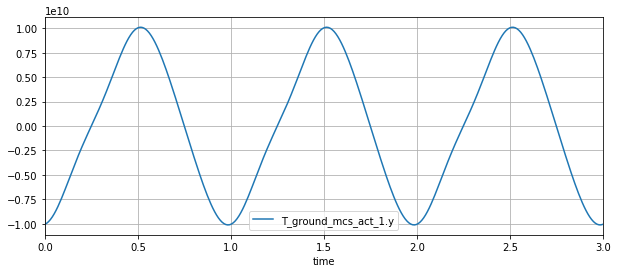

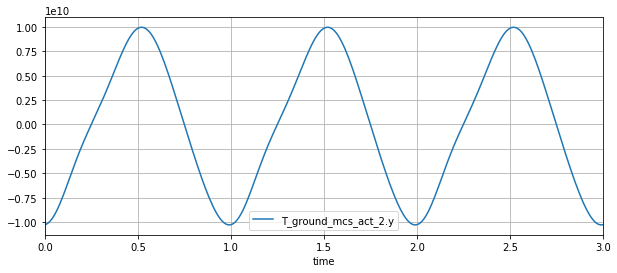

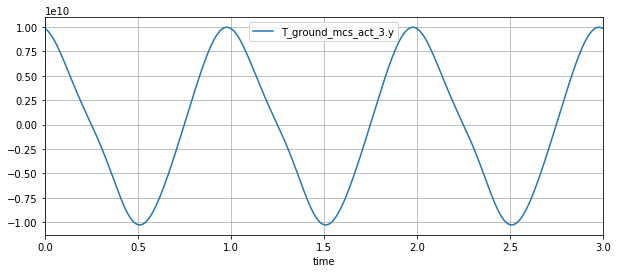

In [42]:
sim1.soln.reactions_dataframe.plot(x='time', y='T_ground_mcs_act_1.y', grid=True, figsize=(10,4))
sim1.soln.reactions_dataframe.plot(x='time', y='T_ground_mcs_act_2.y', grid=True, figsize=(10,4))
sim1.soln.reactions_dataframe.plot(x='time', y='T_ground_mcs_act_3.y', grid=True, figsize=(10,4))

---------------------------------------------------------------
---------------------------------------------------------------

## **C++ NUMERICAL SIMULATION**
-------------------------------

***TO DO BRIEF***

The C++ numerical environment provides samples of **Makefile** and **main.cpp** files that can be used to create, compile and run an executable of the created model.

In order to create a valid environment, we have to edit the **Makefile** and the **main.cpp** files to match the model variables as shown below. These edits can be carried out on the text files using any text editor normally, but for completeness and compatibility with the **Jupyter Notebook** environment the files can be edited here locally using the *Jupyter magic functions*.

First, we check the current working directory, it should be the parent directory that contains [numenv, config_inputs, results, ..], then we use the command```%cd numenv/cpp_eigen/``` to change the working directory.

In [43]:
# Changing the current working directory to 'numenv/cpp_eigen/'
%cd numenv/cpp_eigen/

/home/khaledghobashy/Documents/smbd/examples/notebooks/stewart_gough/numenv/cpp_eigen


---------------------------------------------------

### **Editing the main.cpp file**
#### Using the ```%load ``` magic function.
-------------------------------------------
Then we use the command ```%load main.cpp```, this will load the generated **main.cpp** content in the current cell where we can edit the content. The edits are as follows:
- Remove the first line ```# %load main.cpp``` and insert the line ```%%writefile new_main.cpp```.
- Change the variables topology and configuration in the include directive to match the names of the model generated source files.
- Start specifying the configuration numerical data via the ```Config``` class.
    
After these edits, just run the cell like any normal cell via Shift+Enter.

#### Using the ```%cat ``` magic function.
-------------------------------------------
Then we use the command ```%cat main.cpp```, this will load the generated **main.cpp** content as the output of the current cell, we can then copy the content and past and edit it in another cell. The edits are as follows:
- Insert the line ```%%writefile new_main.cpp``` at the top of the cell.
- Change the variables topology and configuration in the include directive to match the names of the model generated source files.
- Start specifying the configuration numerical data via the ```Config``` class.
    
After these edits, just run the cell like any normal cell via Shift+Enter.

In [44]:
%cat main.cpp


#include <iostream>

#include "smbd/solvers.hpp"

#include "src/topology.hpp"
#include "src/configuration.hpp"


int main()
{
    Topology model("");
    auto Config = ConfigurationInputs<Configuration>(model.config);

    // assign the configuration inputs needed ...

    Config.assemble();

    Solver<Topology> Soln(model);
    Soln.set_time_array(1, 100);
    Soln.Solve();
    Soln.ExportResultsCSV("../results/", 0);

};


In [45]:
%%writefile new_main.cpp

#include <iostream>

#include "smbd/solvers.hpp"

#include "src/stewart_gough.hpp"
#include "src/stewart_gough_cfg.hpp"


int main()
{
    Topology model("");
    auto Config = ConfigurationInputs<Configuration>(model.config);

    // assign the configuration inputs needed ...
    
    Config.R_ground << 0,0,0 ;
    Config.P_ground << 1,0,0,0;

    Config.hps_bottom_1 <<  0, -430, 0 ;
    Config.hps_bottom_2 <<  139, 215, 0 ;
    Config.hps_bottom_3 << -139, 215, 0 ;

    Config.hps_middle_1 << -100, -430, 0 ;
    Config.hps_middle_2 <<  39, 215, 0 ;
    Config.hps_middle_3 << -39, 215, 0 ;

    Config.hps_upper_1 <<  0, -430, 430 ;
    Config.hps_upper_2 <<  139, 215, 430 ;
    Config.hps_upper_3 << -139, 215, 430 ;

    Config.hps_tripod << 0, 0, 390 ;

    Config.s_links_ro = 20 ;
    Config.s_rockers_ro = 20 ;

    Config.vcs_y << 0, 1, 0 ;
    Config.vcs_z << 0, 0, 1 ;

    Config.UF_mcs_act_1 = [](double t)->double{return 2*(22/7)*t;};
    Config.UF_mcs_act_2 = [](double t)->double{return 2*(22/7)*t;};
    Config.UF_mcs_act_3 = [](double t)->double{return 2*(22/7)*t;};

    Config.assemble();

    Solver<Topology> Soln(model);
    Soln.set_time_array(3, 300);
    Soln.Solve();
    Soln.ExportResultsCSV("../../results/", 0);

};


Writing new_main.cpp


---------------------------------------------------

### **Editing the Makefile file**
Following the same steps done for the main.cpp file, then apply the following edits:
- Change the variables MODEL, CONFIG and MAIN to match the generated source files of the topology, configuration and the edited new_main.cpp file.
    
After these edits, just run the cell like any normal cell via Shift+Enter.

In [46]:
%cat Makefile


# Change MODEL, CONFG and MAIN to match the source files you want to build
# ========================================================================
MODEL := topology
CONFG := configuration
MAIN := main.cpp
# ========================================================================


M_BUILD := build/
M_SRC := src/
M_BIN := bin/

NUM_DIR := /home/khaledghobashy/Documents/smbd/smbd/numenv/cpp_eigen/numerics

SMBD_SRC := $(NUM_DIR)/src
SMBD_BUILD := $(NUM_DIR)/build

SMBD_OBJS = $(SMBD_BUILD)/*.o

DEPS := $(M_BUILD)$(MODEL).o $(MAIN) $(M_SRC)$(CONFG).hpp $(SMBD_SRC)/smbd/solvers.hpp

INC := -I $(SMBD_SRC)
CC := g++


$(M_BIN)$(MODEL): $(DEPS) $(SMBD_OBJS)
	$(CC) $(INC) $(M_BUILD)$(MODEL).o $(MAIN) $(SMBD_OBJS) -o $@

$(M_BUILD)$(MODEL).o: $(M_SRC)$(MODEL).cpp $(M_SRC)$(MODEL).hpp
	$(CC) $(INC) -c -o $@ $<


$(SMBD_BUILD)/%.o: $(SMBD_SRC)/smbd/%.cpp $(SMBD_SRC)/smbd/%.hpp
	cd $(SMBD_SRC)/../ && make


clear:
	rm $(M_BUILD)*.o $(M_BIN)$(MODEL)


In [47]:
%%writefile Makefile

# Change MODEL, CONFG and MAIN to match the source files you want to build
# ========================================================================
MODEL := stewart_gough
CONFG := stewart_gough_cfg
MAIN := new_main.cpp
# ========================================================================


M_BUILD := build/
M_SRC := src/
M_BIN := bin/

NUM_DIR := /home/khaledghobashy/Documents/smbd/smbd/numenv/cpp_eigen/numerics

SMBD_SRC := $(NUM_DIR)/src
SMBD_BUILD := $(NUM_DIR)/build

SMBD_OBJS = $(SMBD_BUILD)/*.o

DEPS := $(M_BUILD)$(MODEL).o $(MAIN) $(M_SRC)$(CONFG).hpp $(SMBD_SRC)/smbd/solvers.hpp

INC := -I $(SMBD_SRC)
CC := g++


$(M_BIN)$(MODEL): $(DEPS) $(SMBD_OBJS)
	$(CC) $(INC) $(M_BUILD)$(MODEL).o $(MAIN) $(SMBD_OBJS) -o $@

$(M_BUILD)$(MODEL).o: $(M_SRC)$(MODEL).cpp $(M_SRC)$(MODEL).hpp
	$(CC) $(INC) -c -o $@ $<

    
$(SMBD_BUILD)/%.o: $(SMBD_SRC)/smbd/%.cpp $(SMBD_SRC)/smbd/%.hpp
	cd $(SMBD_SRC)/../ && make
    

clear:
	rm $(M_BUILD)*.o $(M_BIN)$(MODEL)


Overwriting Makefile


### Running ```make``` command

In [48]:
!make

g++ -I /home/khaledghobashy/Documents/smbd/smbd/numenv/cpp_eigen/numerics/src -c -o build/stewart_gough.o src/stewart_gough.cpp
g++ -I /home/khaledghobashy/Documents/smbd/smbd/numenv/cpp_eigen/numerics/src build/stewart_gough.o new_main.cpp /home/khaledghobashy/Documents/smbd/smbd/numenv/cpp_eigen/numerics/build/*.o -o bin/stewart_gough


### Running the executable.

In [49]:
!bin/stewart_gough

Starting Solver ...
[=================================================>] 299 

Positions results saved as : ../../results/Positions.csv


### Loading and Plotting Results.

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

In [51]:
data = pd.read_csv('../../results/Positions.csv')

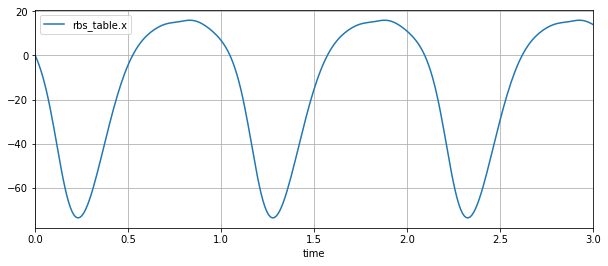

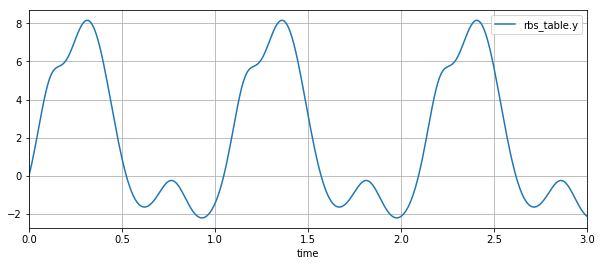

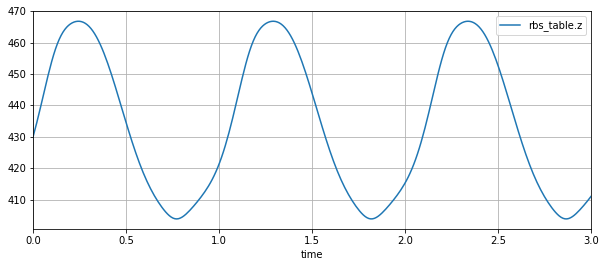

In [52]:
data.plot(x='time', y='rbs_table.x', grid=True, figsize=(10,4))
data.plot(x='time', y='rbs_table.y', grid=True, figsize=(10,4))
data.plot(x='time', y='rbs_table.z', grid=True, figsize=(10,4))